In [3]:
# Cell 1: Setup and Path Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Your dataset path - UPDATE THIS TO YOUR ACTUAL PATH
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")

plt.style.use('default')  # Changed from seaborn-v0_8 for compatibility
sns.set_palette("husl")

print(f"Dataset path: {BASE_PATH}")
print(f"Dataset exists: {BASE_PATH.exists()}")

# Check for CSV files
csv_files = list(BASE_PATH.glob("*.csv"))
print(f"CSV files found: {[f.name for f in csv_files]}")

Dataset path: D:\Projects\CLARITY\Model\Dataset\archive
Dataset exists: True
CSV files found: ['BBox_List_2017.csv', 'Data_Entry_2017.csv']


In [4]:
# Cell 2: Load Metadata and Create Image Mapping
def load_nested_dataset(base_path):
    """Load dataset with nested folder structure"""
    
    # First check for Data_Entry_2017.csv (main labels)
    data_entry_path = base_path / "Data_Entry_2017.csv"
    if data_entry_path.exists():
        df = pd.read_csv(data_entry_path)
        metadata_type = "Disease Labels (Data_Entry_2017.csv)"
    else:
        # Fallback to BBox_List_2017.csv
        bbox_path = base_path / "BBox_List_2017.csv"
        if bbox_path.exists():
            df = pd.read_csv(bbox_path)
            metadata_type = "Bounding Box Data (BBox_List_2017.csv)"
            print("⚠️  Using BBox data - you'll need Data_Entry_2017.csv for disease classification")
        else:
            print("❌ No metadata CSV found!")
            return None, None, None
    
    print(f"✅ Metadata loaded from: {metadata_type}")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {list(df.columns)}")
    
    # Create image mapping for nested structure
    image_mapping = {}
    
    print(f"\n🗺️  Creating image path mapping...")
    
    # Navigate the nested structure: images_XXX/images/*.png
    for main_folder in sorted(base_path.iterdir()):
        if main_folder.is_dir() and main_folder.name.startswith('images_'):
            
            # Look for 'images' subfolder
            images_subfolder = main_folder / 'images'
            
            if images_subfolder.exists():
                print(f"   📂 Processing {main_folder.name}/images/")
                
                folder_count = 0
                for img_file in images_subfolder.glob("*.png"):
                    image_name = img_file.name
                    
                    # Only keep first occurrence (handle any duplicates)
                    if image_name not in image_mapping:
                        image_mapping[image_name] = img_file
                        folder_count += 1
                
                print(f"      └── Added {folder_count:,} unique images")
    
    print(f"\n✅ Total unique images mapped: {len(image_mapping):,}")
    
    return df, image_mapping, metadata_type

# Load your nested dataset
df, image_mapping, metadata_type = load_nested_dataset(BASE_PATH)

✅ Metadata loaded from: Disease Labels (Data_Entry_2017.csv)
   Rows: 112,120
   Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

🗺️  Creating image path mapping...
   📂 Processing images_001/images/
      └── Added 4,999 unique images
   📂 Processing images_002/images/
      └── Added 10,000 unique images
   📂 Processing images_003/images/
      └── Added 10,000 unique images
   📂 Processing images_004/images/
      └── Added 10,000 unique images
   📂 Processing images_005/images/
      └── Added 10,000 unique images
   📂 Processing images_006/images/
      └── Added 10,000 unique images
   📂 Processing images_007/images/
      └── Added 10,000 unique images
   📂 Processing images_008/images/
      └── Added 10,000 unique images
   📂 Processing images_009/images/
      └── Added 10,000 unique images
   📂 Processing images_010/i

In [5]:
# Cell 3: Dataset Overview
if df is not None:
    print("=== DATASET OVERVIEW ===")
    print(f"Metadata type: {metadata_type}")
    print(f"Total metadata entries: {len(df):,}")
    print(f"Unique images available: {len(image_mapping):,}")
    
    # Check Image Index column
    if 'Image Index' in df.columns:
        metadata_images = set(df['Image Index'])
        mapped_images = set(image_mapping.keys())
        
        missing_images = metadata_images - mapped_images
        extra_images = mapped_images - metadata_images
        
        print(f"Dataset completeness: {len(mapped_images)/len(metadata_images)*100:.1f}%")
        print(f"Missing from disk: {len(missing_images):,}")
        print(f"Extra on disk: {len(extra_images):,}")
        
    else:
        print("⚠️  'Image Index' column not found - check CSV structure")
    
    # Show first few rows
    print(f"\nFirst 3 rows of metadata:")
    print(df.head(3))
    
    # Column information
    print(f"\nColumn details:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col} ({df[col].dtype})")

=== DATASET OVERVIEW ===
Metadata type: Disease Labels (Data_Entry_2017.csv)
Total metadata entries: 112,120
Unique images available: 112,120
Dataset completeness: 100.0%
Missing from disk: 0
Extra on disk: 0

First 3 rows of metadata:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2      

In [11]:
# Cell 4: Check for Disease Labels (Main Analysis) - FIXED
if df is not None and 'Finding Labels' in df.columns:
    print("=== DISEASE CLASSIFICATION ANALYSIS ===")
    
    # Check unique patients if column exists
    if 'Patient ID' in df.columns:
        unique_patients = df['Patient ID'].nunique()
        print(f"Unique patients: {unique_patients:,}")
        print(f"Average images per patient: {len(df)/unique_patients:.1f}")
    
    # Extract all disease findings
    all_findings = []
    multi_label_cases = 0
    
    for findings_str in df['Finding Labels']:
        if '|' in str(findings_str):
            # Multi-label case
            multi_label_cases += 1
            findings_list = str(findings_str).split('|')
            all_findings.extend(findings_list)
        else:
            # Single label
            all_findings.append(str(findings_str))
    
    # Count disease frequencies
    disease_counts = pd.Series(all_findings).value_counts()
    
    print(f"Total disease instances: {len(all_findings):,}")
    print(f"Unique disease classes: {len(disease_counts)}")
    print(f"Multi-label cases: {multi_label_cases:,} ({multi_label_cases/len(df)*100:.1f}%)")
    
    # Show all diseases with counts
    print(f"\nComplete Disease Distribution:")
    print("-" * 60)
    
    for i, (disease, count) in enumerate(disease_counts.items(), 1):
        percentage = (count / len(all_findings)) * 100
        print(f"{i:2d}. {disease:.<35} {count:>8,} ({percentage:>5.1f}%)")
    
    # Class imbalance analysis - FIXED
    most_common_count = disease_counts.iloc[0]  # Added [0]
    least_common_count = disease_counts.iloc[-1]
    imbalance_ratio = most_common_count / least_common_count
    
    print(f"\nClass Imbalance Analysis:")
    print(f"Most common: {disease_counts.index[0]} ({most_common_count:,} cases)")  # Added [0]
    print(f"Least common: {disease_counts.index[-1]} ({least_common_count:,} cases)")
    print(f"Imbalance ratio: {imbalance_ratio:.1f}:1")
    
else:
    print("⚠️  'Finding Labels' column not found - this may be bounding box data only")
    print("You need Data_Entry_2017.csv for disease classification")

=== DISEASE CLASSIFICATION ANALYSIS ===
Unique patients: 30,805
Average images per patient: 3.6
Total disease instances: 141,537
Unique disease classes: 15
Multi-label cases: 20,796 (18.5%)

Complete Disease Distribution:
------------------------------------------------------------
 1. No Finding.........................   60,361 ( 42.6%)
 2. Infiltration.......................   19,894 ( 14.1%)
 3. Effusion...........................   13,317 (  9.4%)
 4. Atelectasis........................   11,559 (  8.2%)
 5. Nodule.............................    6,331 (  4.5%)
 6. Mass...............................    5,782 (  4.1%)
 7. Pneumothorax.......................    5,302 (  3.7%)
 8. Consolidation......................    4,667 (  3.3%)
 9. Pleural_Thickening.................    3,385 (  2.4%)
10. Cardiomegaly.......................    2,776 (  2.0%)
11. Emphysema..........................    2,516 (  1.8%)
12. Edema..............................    2,303 (  1.6%)
13. Fibrosis.........

<Figure size 1600x1200 with 0 Axes>

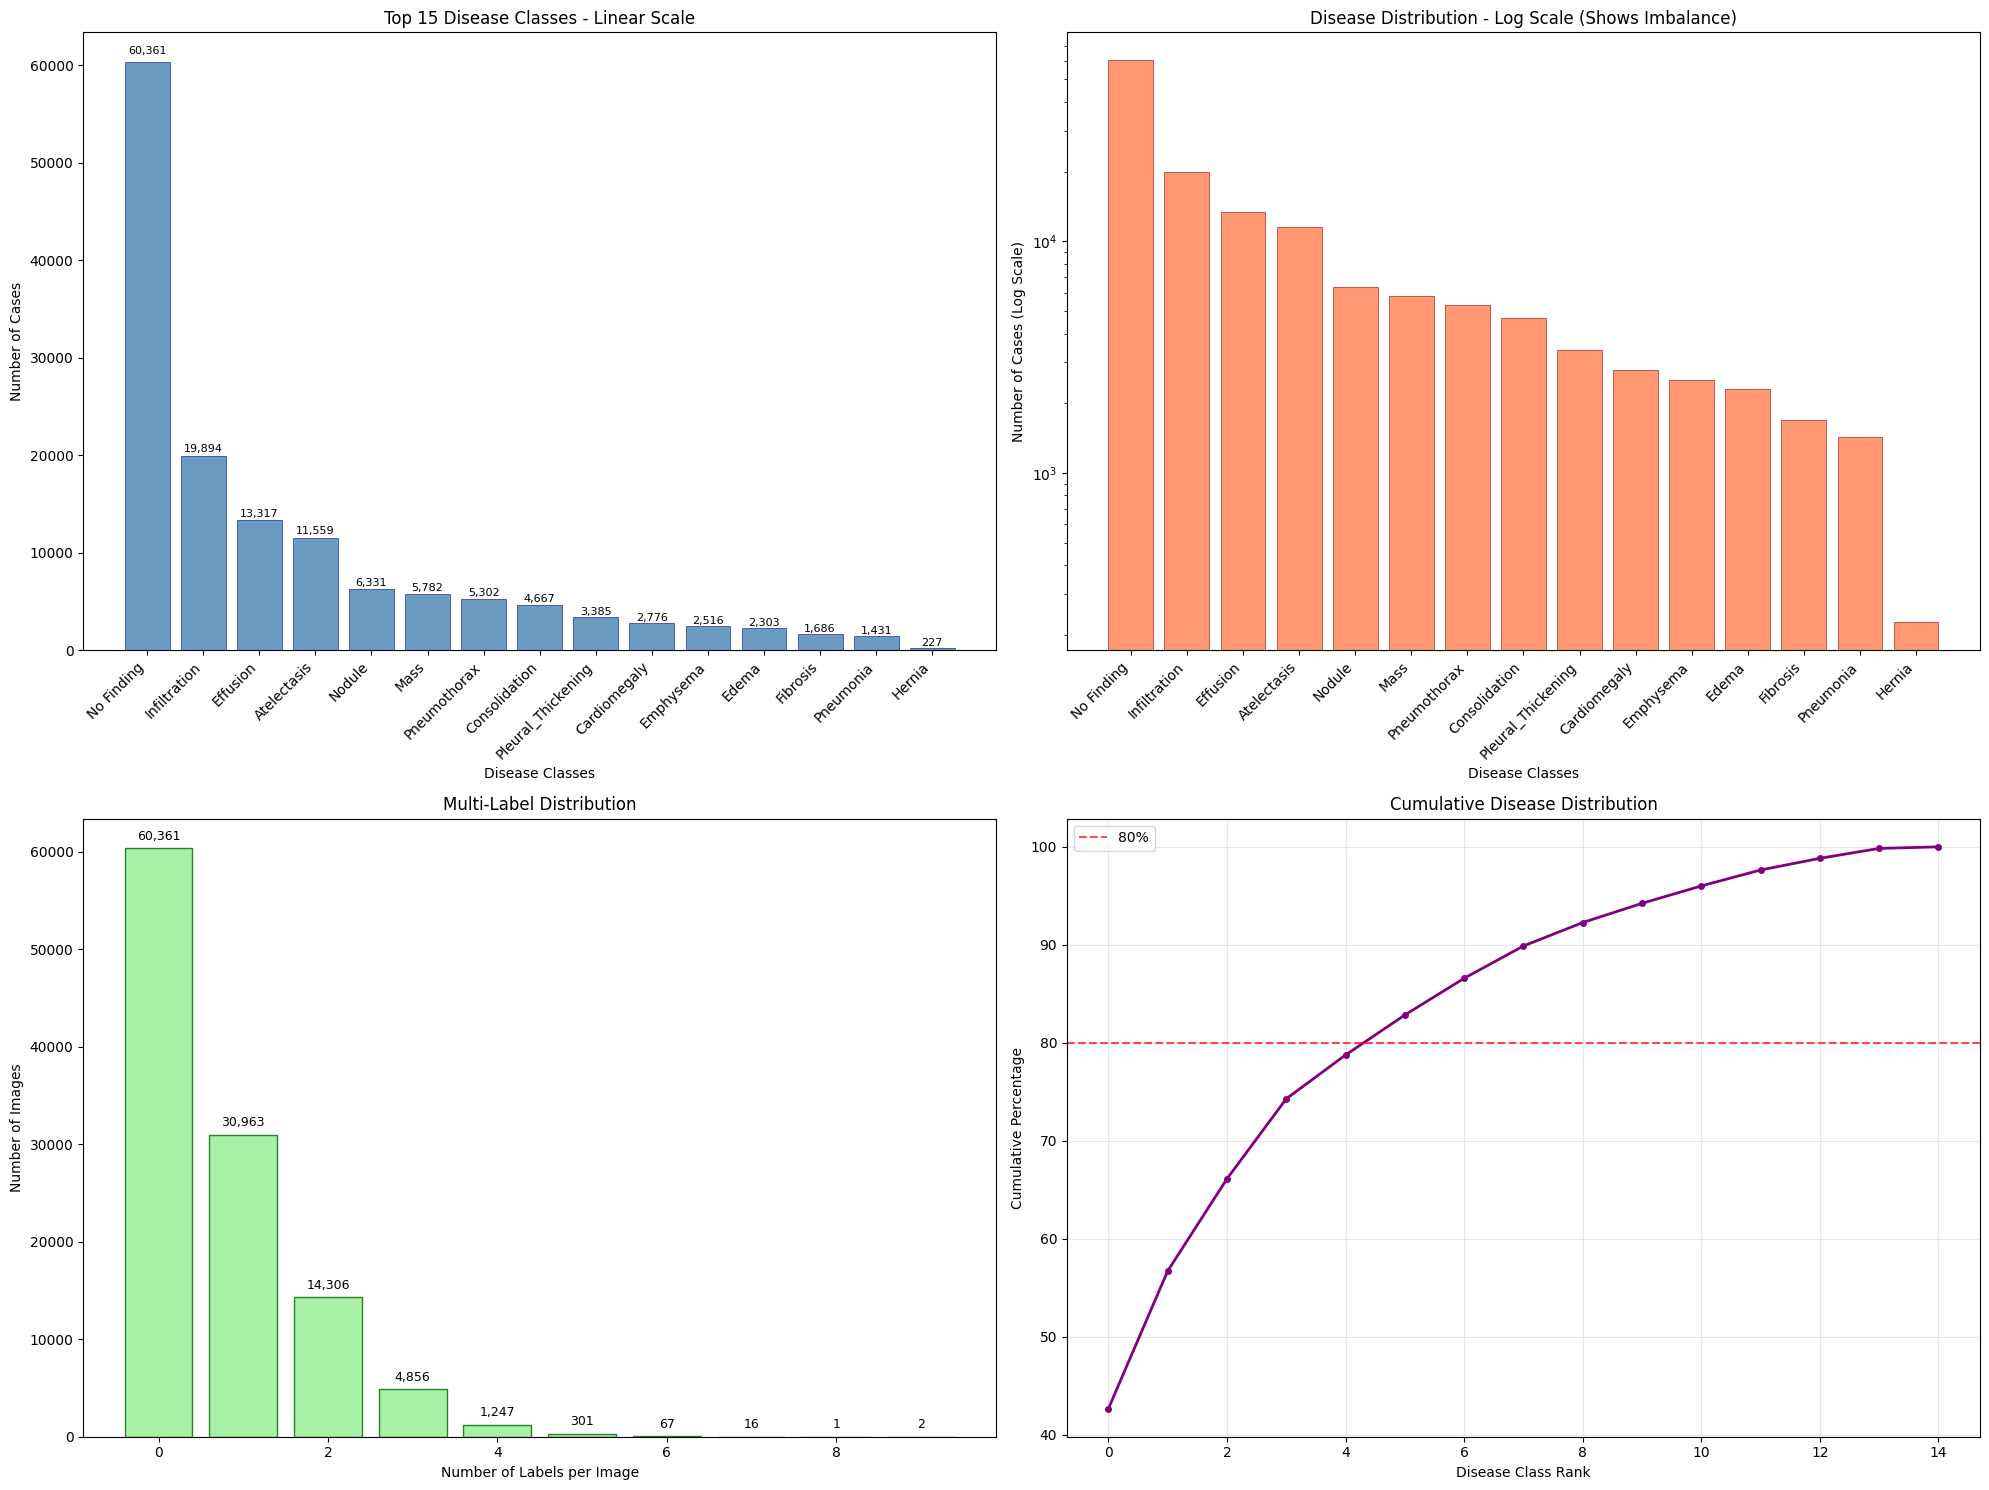

In [7]:
# Cell 5: Visualize Disease Distribution
if 'disease_counts' in locals():
    plt.figure(figsize=(16, 12))
    
    # Get top 15 diseases for visualization
    top_diseases = disease_counts.head(15)
    
    # Create subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. Standard bar plot
    bars1 = axes[0,0].bar(range(len(top_diseases)), top_diseases.values, 
                         color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
    axes[0,0].set_xlabel('Disease Classes')
    axes[0,0].set_ylabel('Number of Cases')
    axes[0,0].set_title('Top 15 Disease Classes - Linear Scale')
    axes[0,0].set_xticks(range(len(top_diseases)))
    axes[0,0].set_xticklabels(top_diseases.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # 2. Log scale plot to show imbalance
    bars2 = axes[0,1].bar(range(len(top_diseases)), top_diseases.values, 
                         color='coral', alpha=0.8, edgecolor='darkred', linewidth=0.5)
    axes[0,1].set_xlabel('Disease Classes')
    axes[0,1].set_ylabel('Number of Cases (Log Scale)')
    axes[0,1].set_title('Disease Distribution - Log Scale (Shows Imbalance)')
    axes[0,1].set_yscale('log')
    axes[0,1].set_xticks(range(len(top_diseases)))
    axes[0,1].set_xticklabels(top_diseases.index, rotation=45, ha='right')
    
    # 3. Multi-label analysis
    if 'multi_label_cases' in locals():
        df['label_count'] = df['Finding Labels'].apply(
            lambda x: len(str(x).split('|')) if str(x) != 'No Finding' else 0
        )
        label_dist = df['label_count'].value_counts().sort_index()
        
        bars3 = axes[1,0].bar(label_dist.index, label_dist.values, 
                             color='lightgreen', alpha=0.8, edgecolor='darkgreen')
        axes[1,0].set_xlabel('Number of Labels per Image')
        axes[1,0].set_ylabel('Number of Images')
        axes[1,0].set_title('Multi-Label Distribution')
        
        for i, v in enumerate(label_dist.values):
            axes[1,0].text(label_dist.index[i], v + len(df)*0.005, 
                          f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. Cumulative distribution
    cumulative_pct = (disease_counts.cumsum() / disease_counts.sum() * 100)
    axes[1,1].plot(range(len(cumulative_pct)), cumulative_pct.values, 
                   marker='o', linewidth=2, markersize=4, color='purple')
    axes[1,1].set_xlabel('Disease Class Rank')
    axes[1,1].set_ylabel('Cumulative Percentage')
    axes[1,1].set_title('Cumulative Disease Distribution')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80%')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

=== PATIENT DEMOGRAPHICS ANALYSIS ===
Age Statistics:
count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

Gender Distribution:
Patient Gender
M    63340
F    48780
Name: count, dtype: int64
Male/Female ratio: 1.30:1

View Position Distribution:
View Position
PA    67310
AP    44810
Name: count, dtype: int64


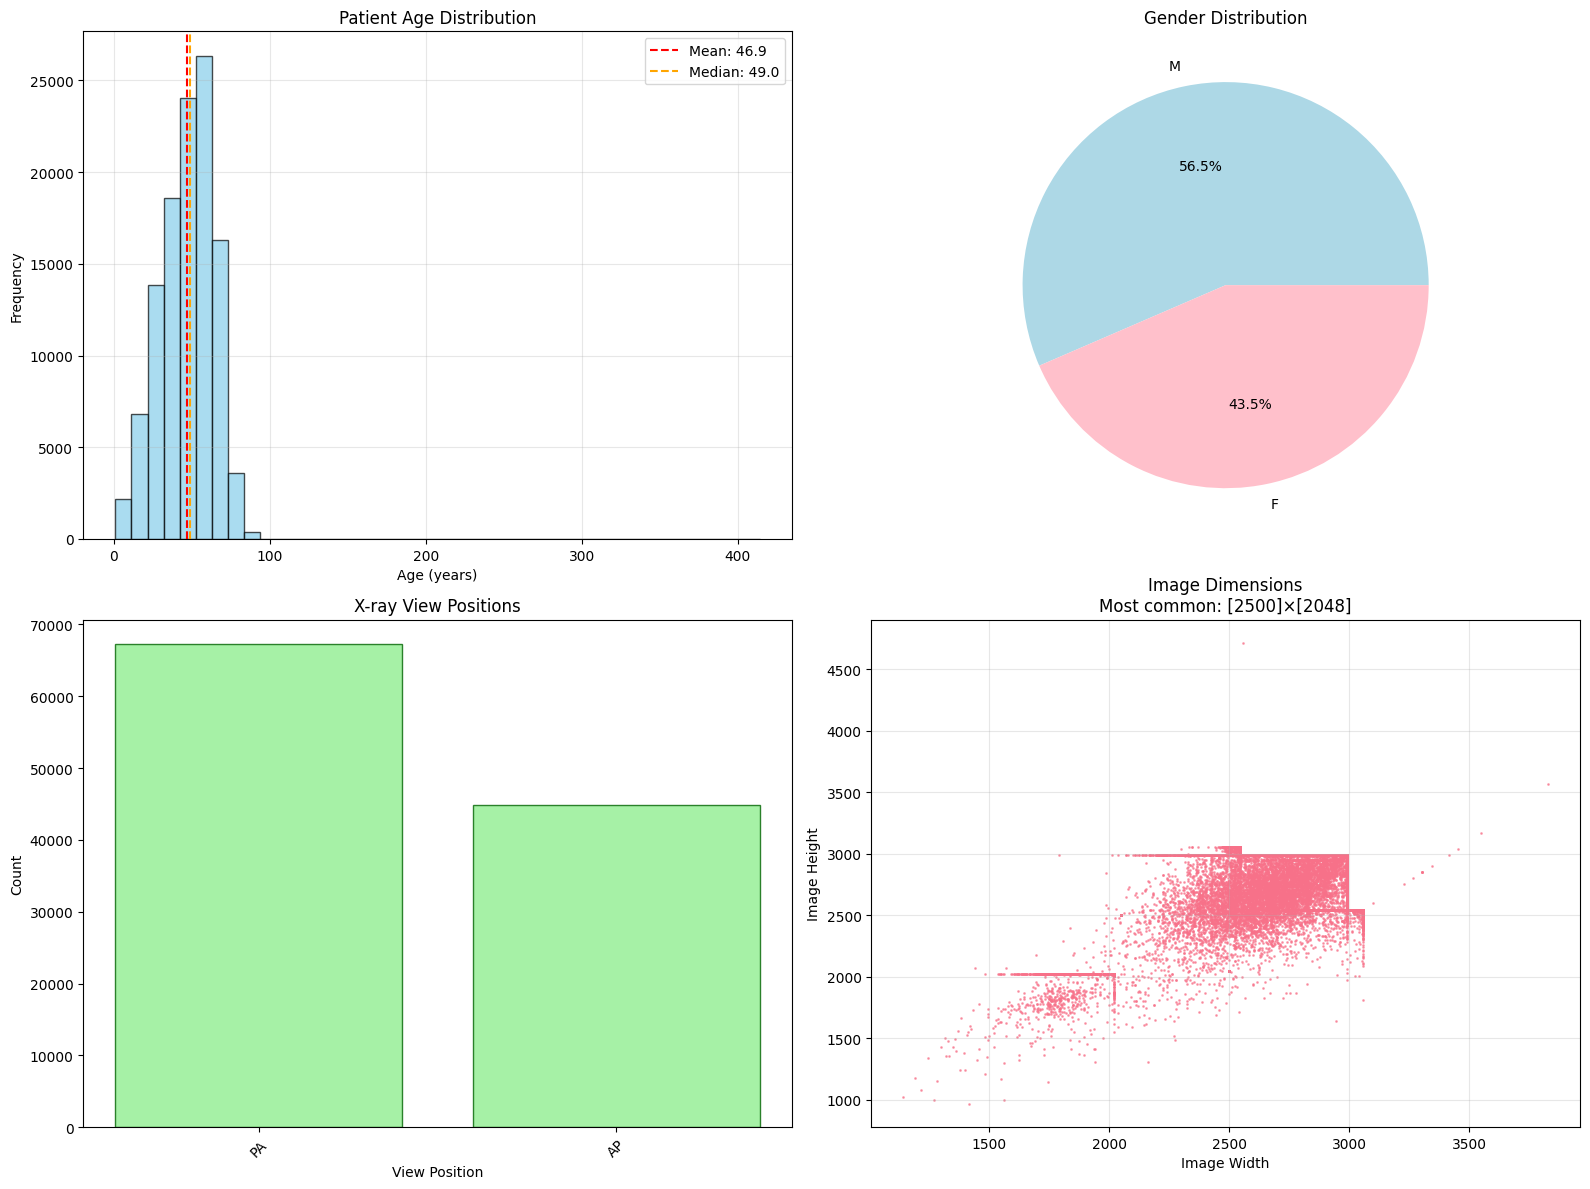

In [8]:
# Cell 6: Patient Demographics Analysis
if df is not None and 'Patient Age' in df.columns:
    print("=== PATIENT DEMOGRAPHICS ANALYSIS ===")
    
    # Age analysis
    age_stats = df['Patient Age'].describe()
    print(f"Age Statistics:")
    print(age_stats)
    
    # Gender analysis
    if 'Patient Gender' in df.columns:
        gender_counts = df['Patient Gender'].value_counts()
        print(f"\nGender Distribution:")
        print(gender_counts)
        print(f"Male/Female ratio: {gender_counts.get('M', 0)/gender_counts.get('F', 1):.2f}:1")
    
    # View position analysis
    if 'View Position' in df.columns:
        view_counts = df['View Position'].value_counts()
        print(f"\nView Position Distribution:")
        print(view_counts)
    
    # Create demographics visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Age histogram
    axes[0,0].hist(df['Patient Age'], bins=40, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(df['Patient Age'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {df["Patient Age"].mean():.1f}')
    axes[0,0].axvline(df['Patient Age'].median(), color='orange', linestyle='--', 
                     label=f'Median: {df["Patient Age"].median():.1f}')
    axes[0,0].set_xlabel('Age (years)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Patient Age Distribution')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)
    
    # Gender pie chart
    if 'Patient Gender' in df.columns:
        axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                     colors=['lightblue', 'pink'])
        axes[0,1].set_title('Gender Distribution')
    
    # View positions
    if 'View Position' in df.columns:
        axes[1,0].bar(view_counts.index, view_counts.values, 
                     color='lightgreen', alpha=0.8, edgecolor='darkgreen')
        axes[1,0].set_xlabel('View Position')
        axes[1,0].set_ylabel('Count')
        axes[1,0].set_title('X-ray View Positions')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Image dimensions
    if 'OriginalImage[Width' in df.columns and 'Height]' in df.columns:
        width_mode = df['OriginalImage[Width'].mode().values
        height_mode = df['Height]'].mode().values
        
        axes[1,1].scatter(df['OriginalImage[Width'], df['Height]'], alpha=0.6, s=1)
        axes[1,1].set_xlabel('Image Width')
        axes[1,1].set_ylabel('Image Height')
        axes[1,1].set_title(f'Image Dimensions\nMost common: {width_mode}×{height_mode}')
        axes[1,1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


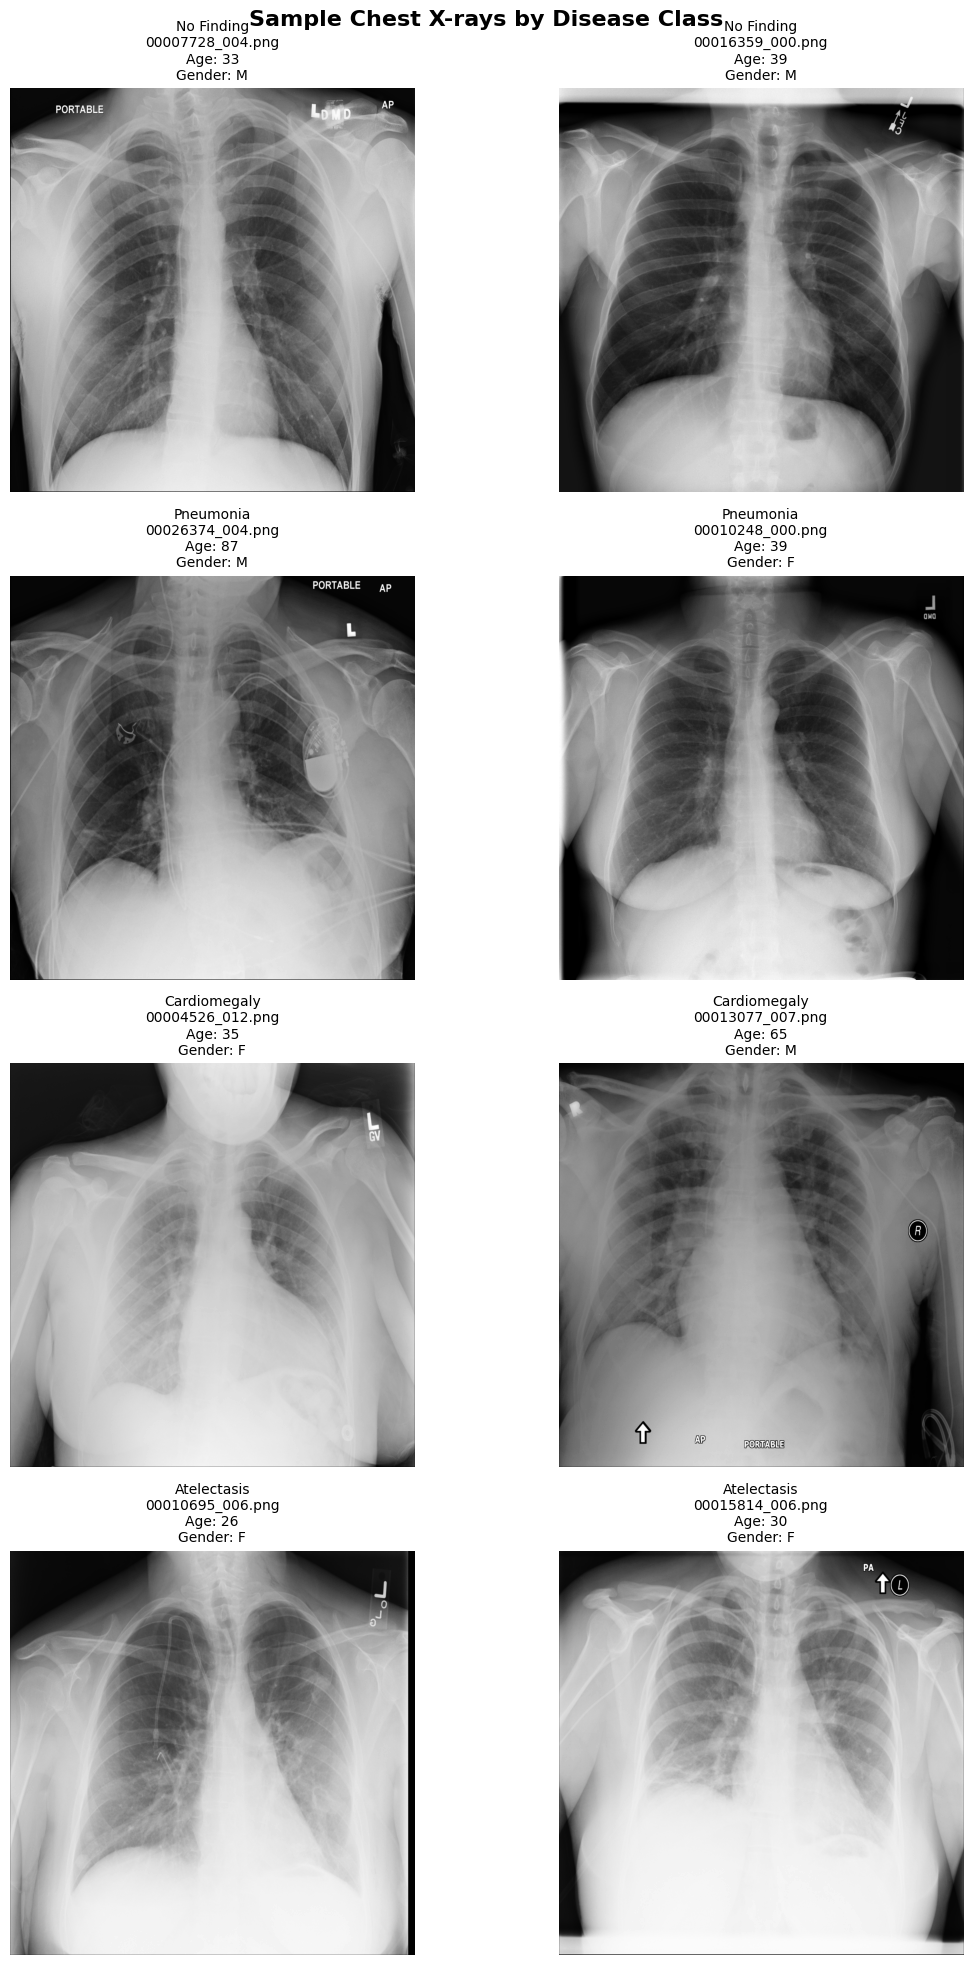

In [9]:
# Cell 7: Sample Image Display
def display_sample_images_nested(image_mapping, df, diseases=None, samples_per_disease=2):
    """Display sample images from nested dataset structure"""
    
    if diseases is None and 'Finding Labels' in df.columns:
        diseases = ['No Finding', 'Pneumonia', 'Cardiomegaly', 'Atelectasis']
    elif diseases is None:
        print("⚠️  Cannot display disease samples - no Finding Labels column")
        return
    
    rows = len(diseases)
    cols = samples_per_disease
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, disease in enumerate(diseases):
        # Find images with this disease
        if disease == 'No Finding':
            disease_mask = df['Finding Labels'] == disease
        else:
            disease_mask = df['Finding Labels'].str.contains(disease, na=False)
        
        disease_images = df[disease_mask]
        
        if len(disease_images) > 0:
            # Try to get multiple samples
            sample_size = min(samples_per_disease * 3, len(disease_images))
            disease_samples = disease_images.sample(n=sample_size) if sample_size > 0 else disease_images
            
            samples_loaded = 0
            for j in range(cols):
                if samples_loaded < samples_per_disease and len(disease_samples) > samples_loaded:
                    # Try to load image
                    for _, row in disease_samples.iloc[samples_loaded:].iterrows():
                        image_name = row['Image Index']
                        
                        if image_name in image_mapping:
                            try:
                                img_path = image_mapping[image_name]
                                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                                
                                if img is not None:
                                    axes[i,j].imshow(img, cmap='gray')
                                    
                                    # Create title with metadata
                                    title_parts = [disease, image_name]
                                    if 'Patient Age' in row:
                                        title_parts.append(f"Age: {row['Patient Age']}")
                                    if 'Patient Gender' in row:
                                        title_parts.append(f"Gender: {row['Patient Gender']}")
                                    
                                    axes[i,j].set_title('\n'.join(title_parts), fontsize=10)
                                    axes[i,j].axis('off')
                                    samples_loaded += 1
                                    break
                            except Exception as e:
                                print(f"Error loading {image_name}: {e}")
                                continue
                
                if samples_loaded <= j:
                    # No more images available
                    axes[i,j].text(0.5, 0.5, f'No more\n{disease}\nimages\navailable', 
                                 ha='center', va='center', transform=axes[i,j].transAxes,
                                 fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat'))
                    axes[i,j].axis('off')
        else:
            # No images found for this disease
            for j in range(cols):
                axes[i,j].text(0.5, 0.5, f'No images\nfound for\n{disease}', 
                             ha='center', va='center', transform=axes[i,j].transAxes,
                             fontsize=12, bbox=dict(boxstyle="round", facecolor='lightcoral'))
                axes[i,j].axis('off')
    
    plt.suptitle('Sample Chest X-rays by Disease Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display sample images
if image_mapping and len(image_mapping) > 0 and df is not None:
    display_sample_images_nested(image_mapping, df)
else:
    print("❌ Cannot display images - check dataset loading")

In [12]:
# Cell 8: Generate Research Summary - FIXED
if df is not None and image_mapping is not None:
    
    research_summary = {
        'Dataset': 'NIH ChestX-ray14',
        'Dataset Structure': 'Nested (12 folders → images subfolders)',
        'Total Images (Metadata)': f"{len(df):,}",
        'Unique Images Available': f"{len(image_mapping):,}",
        'Dataset Completeness': f"{len(image_mapping)/len(df)*100:.1f}%" if 'Image Index' in df.columns else 'N/A',
    }
    
    # Add patient info if available
    if 'Patient ID' in df.columns:
        unique_patients = df['Patient ID'].nunique()
        research_summary['Unique Patients'] = f"{unique_patients:,}"
        research_summary['Images per Patient (avg)'] = f"{len(df)/unique_patients:.1f}"
    
    # Add disease info if available - FIXED
    if 'disease_counts' in locals():
        research_summary['Disease Classes'] = f"{len(disease_counts)}"
        research_summary['Most Common Finding'] = f"{disease_counts.index[0]} ({disease_counts.iloc[0]:,})"  # Added [0]
        research_summary['Rarest Finding'] = f"{disease_counts.index[-1]} ({disease_counts.iloc[-1]:,})"
        research_summary['Class Imbalance Ratio'] = f"{imbalance_ratio:.0f}:1"
        
        if 'multi_label_cases' in locals():
            multi_label_pct = multi_label_cases/len(df)*100
            research_summary['Multi-label Images'] = f"{multi_label_pct:.1f}%"
    
    # Add demographics if available
    if 'Patient Age' in df.columns:
        research_summary['Age Range'] = f"{df['Patient Age'].min():.0f}-{df['Patient Age'].max():.0f} years"
    
    if 'Patient Gender' in df.columns:
        gender_dist = df['Patient Gender'].value_counts()
        research_summary['Gender Distribution'] = f"M: {gender_dist.get('M', 0):,}, F: {gender_dist.get('F', 0):,}"
    
    # Add image properties if available
    if 'OriginalImage[Width' in df.columns and 'Height]' in df.columns:
        width_mode = df['OriginalImage[Width'].mode().values[0]
        height_mode = df['Height]'].mode().values[0]
        research_summary['Common Image Size'] = f"{width_mode:.0f}×{height_mode:.0f}"
    
    print("\n" + "="*80)
    print("COMPREHENSIVE DATASET SUMMARY FOR RESEARCH PUBLICATION")
    print("="*80)
    
    for key, value in research_summary.items():
        print(f"{key:.<50} {value:>25}")
    
    print("="*80)
    
    # Save summary
    summary_df = pd.DataFrame(list(research_summary.items()), 
                            columns=['Metric', 'Value'])
    summary_path = BASE_PATH / 'research_dataset_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    
    print(f"\n✅ Research summary saved to: {summary_path}")
    
    # Key insights for paper - FIXED
    print(f"\n🎯 KEY INSIGHTS FOR YOUR RESEARCH PAPER:")
    if len(image_mapping) > 100000:
        print(f"   • Large-scale medical dataset: {len(df):,} chest X-rays")
    if 'unique_patients' in locals():
        print(f"   • Clinical diversity: {unique_patients:,} unique patients")
    if 'disease_counts' in locals():
        print(f"   • Multi-class challenge: {len(disease_counts)} disease categories")
    if 'multi_label_cases' in locals():
        print(f"   • Real-world complexity: {multi_label_pct:.1f}% multi-label cases")
    if 'imbalance_ratio' in locals():
        print(f"   • Class imbalance challenge: {imbalance_ratio:.0f}:1 ratio")
    
    print(f"\n🚀 DATASET ANALYSIS COMPLETE - READY FOR MODEL TRAINING!")
    
else:
    print("❌ Cannot generate summary - dataset not properly loaded")


COMPREHENSIVE DATASET SUMMARY FOR RESEARCH PUBLICATION
Dataset...........................................          NIH ChestX-ray14
Dataset Structure................................. Nested (12 folders → images subfolders)
Total Images (Metadata)...........................                   112,120
Unique Images Available...........................                   112,120
Dataset Completeness..............................                    100.0%
Unique Patients...................................                    30,805
Images per Patient (avg)..........................                       3.6
Disease Classes...................................                        15
Most Common Finding...............................       No Finding (60,361)
Rarest Finding....................................              Hernia (227)
Class Imbalance Ratio.............................                     266:1
Multi-label Images................................                     18.5%
Age Ra